<a href="https://www.kaggle.com/code/peremartramanonellas/guide-multiple-outputs-with-keras-functional-api?scriptVersionId=124611868" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
 from IPython.core.display import HTML
HTML("""
<style>
font-family: monospace;
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: AliceBlue;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 2px
}

h2 {
    text-align: center;
    background-color: HoneyDew;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 2px
}

h3 {
    text-align: center;
    background-color: MintCream;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 2px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")

# Tutorial to create a Multi Output Tensorflow Model using Keras API

In this notebook we are going to create with TensorFlow a model able to predict two variables: 
- **Classification variable** to identify the tipe of wine. 
- **Regression variable** who qualifies the quality of the wine. 

I'm using a Dataset from Kaggle: https://www.kaggle.com/datasets/rajyellow46/wine-quality
It's a really simple tabular dataset containing some caracteristics of the wine, like acidity, sugar, chlorides... etc. And two values that can be labels: the type of wine and the quality. 

I'm going to do some Data cleaning, but it is not the focus of the Notebook. The focus is to show how we can use the Keras functional API to create a Model able to predict both variables. 

## Are this kind of models useful? 
YES!  Maybe not in an environment like Kaggle, where we are competing to obtain the best score. But in the real world this kind of models can be really useful. 

Yo can save a lot of time in training and prediction, and a lot of computation hours. You can save time and money if you can use the same model to predict more than one variable. 

Just imagine a pipeline where the model must be retrained every day with millions of data, and with this data we can predict two or more variables. You don't need to train two or more models, you can use just one training process to get all the predictions you want. 

Amazing!!!! 

This models may be more difficult to adjust because we need to share the same hyperparameters for all the variables. But you can use different layers, and it should be enough. 


In [2]:
#Importing the libraries. 

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot

from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import train_test_split

# Load and Prepare the DATA

In [3]:
#Load the file. You have an link to the dataset in the head of the notebook. 
df = pd.read_csv('/kaggle/input/wine-quality/winequalityN.csv')

In [4]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


We need to convert the column type from text to numeric. 

In [5]:
#Converting string column to categorical numeric. 
df['type'] = df['type'].apply(lambda x:0 if (x == 'white') else 1)

In [6]:
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,0,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,0,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,0,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,1,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,1,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,1,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,1,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Our *type* colum now is númeric. 

Let's check if we have some null values. 

In [7]:
#Get the numbers of Null values in columns, in descending order. 
df.isna().sum().sort_values(ascending=False).head(9)

fixed acidity          10
pH                      9
volatile acidity        8
sulphates               4
citric acid             3
residual sugar          2
chlorides               2
type                    0
free sulfur dioxide     0
dtype: int64

There are just a few rows with null / empty values, we can just delete it. 

In [8]:
#Creating the new dataset without null, or empty, values. 
df = df.dropna(axis=0)

In [9]:
#Check if we have more nulls. 
df.isna().sum().sort_values(ascending=False).head(8)

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
dtype: int64

Now we are going to create 3 Datasets. Train, Test and Validation Data. Using the function *train_test_split* from the *sklearn.models*. 

In [10]:
#Create the train and test data. 80% tain and 20 data. 
train, test = train_test_split(df, test_size=0.2, random_state = 1)

#From the train Data we are going to get a 20% more to create the validation data. 
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [11]:
#With this function we got the labels *type* and *quality*,  ready to pass to the Model. 
def get_labels(df):
    type_wine = df.pop('type')
    type_wine = np.array(type_wine)
    quality = df.pop('quality')
    quality = np.array(quality)
    return (quality, type_wine)

In [12]:
#Getting the labels for train, test and validate. 
train_y = get_labels(train)
test_y = get_labels(test)
val_y = get_labels(val)

## Scale values

This is the only treatment that I'm going to do to the Data. It's really simple, and improve a lot the result of the model. 

In [13]:
#Get Mean and std but only from training data. 
train_stats = train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4136.0,7.196905,1.296497,3.80000,6.4000,7.000000,7.62500,15.90000
volatile acidity,4136.0,0.337378,0.163193,0.08000,0.2200,0.290000,0.40000,1.58000
citric acid,4136.0,0.319108,0.144535,0.00000,0.2500,0.310000,0.39000,1.66000
residual sugar,4136.0,5.510638,4.812892,0.60000,1.8000,3.200000,8.20000,65.80000
chlorides,4136.0,0.055627,0.035004,0.01200,0.0380,0.047000,0.06400,0.61100
free sulfur dioxide,4136.0,30.732834,17.917700,1.00000,17.0000,29.000000,42.00000,289.00000
total sulfur dioxide,4136.0,116.689313,56.244277,7.00000,80.0000,119.000000,156.00000,440.00000
density,4136.0,0.994708,0.003034,0.98713,0.9923,0.994885,0.99704,1.03898
pH,4136.0,3.218873,0.160356,2.72000,3.1100,3.210000,3.32000,4.01000
sulphates,4136.0,0.530771,0.148288,0.23000,0.4300,0.510000,0.60000,2.00000


> Note that I used only the train dataset to calculate the mean and std. **It's a good practice don't use the validation or test data to calculate this values** because is how it's going to be in the real world. The model only must know the data used for training, and therefore we must only this dataset to calculate the *mean* and *std*.

I'm going to use the data contained in the *train_stats* to normalize the values in the datasets. 

In [14]:
# Normalize the data, but with the mean and std of only train data. 
def scale_data(df):
    return (df - train_stats['mean']) / train_stats['std']

In [15]:
#Scaling the 3 datasets. 
train_X = scale_data(train)
test_X = scale_data(test)
val_X = scale_data(val)

# The Model

We are going to use the Keras functional API to create the model. The main advantatge is that we don't need to create sequential models. 

In this Model we are going to follow 2 different branches with some base layers shared, but with different output layers and one Dense layer more in one of the branches. 

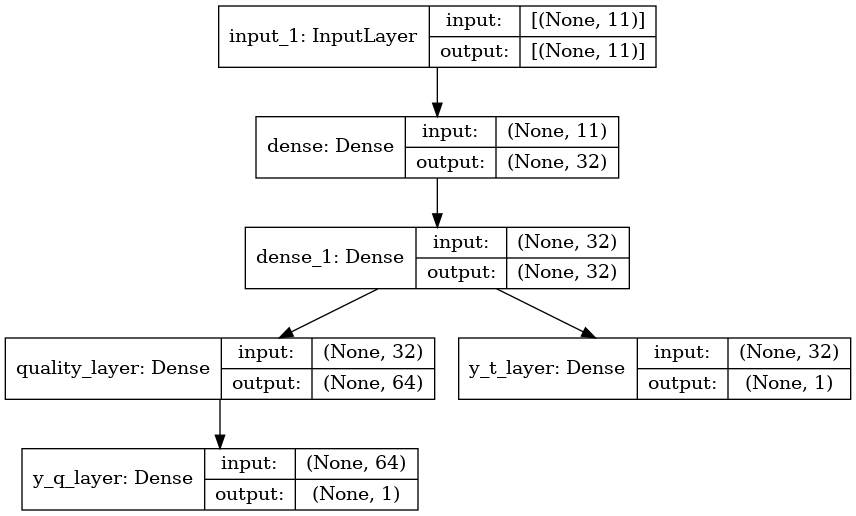

As you can see we have an additionl *Dense layer* with 64 Neurons to calculate the wine quality that it's not in the branch to calculate the wine type. 

In [16]:
#Start with the input layer, where we must indicate the shape of the Data passed to the model. 
inputs = tf.keras.layers.Input(shape=(11,))

#Add dense layers to the input layer. These layers are commom to both predicted variables. 
x = Dense(units=32, activation='relu')(inputs)
x = Dense(units=32, activation='relu')(x)

#Add the output layer for the Wine type using Sigmoid activation. 
y_t_layer = Dense(units = 1, activation='sigmoid', name='y_t_layer')(x)

#Here we diversificate the model adding a new Dense layer to the Base layers (x)
quality_layer=Dense(units=64, name='quality_layer', activation='relu')(x)

#The output layer for the quality wine variable. It's added below the Dense Layer: quality_layer 
y_q_layer = Dense(units=1, name='y_q_layer')(quality_layer)

#The Model is created indicating the inputs and outputs. 
#We have only one Input, but we can create models with multiple inputs. 
#The name in outputs is the same of the variables, and the internal name of the layer. 
model = Model(inputs=inputs, outputs=[y_q_layer, y_t_layer])

#I tested two optimizers and choosed Adam, but feel free to test yourself. 
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
#optimizer = tf.keras.optimizers.Adam()

#To compile the model we use two dictionaries, to indicate the loss functions and metrics 
#for each output layer. Note that the name of the layer must be the same than the 
#internal name of the layer. 
model.compile(optimizer=optimizer, 
              loss = {'y_t_layer' : 'binary_crossentropy', 
                      'y_q_layer' : 'mse'
                     },
              metrics = {'y_t_layer' : 'accuracy', 
                         'y_q_layer': tf.keras.metrics.RootMeanSquaredError()
                       }
             )

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           384         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        dense[0][0]                      
__________________________________________________________________________________________________
quality_layer (Dense)           (None, 64)           2112        dense_1[0][0]                    
______________________________________________________________________________________________

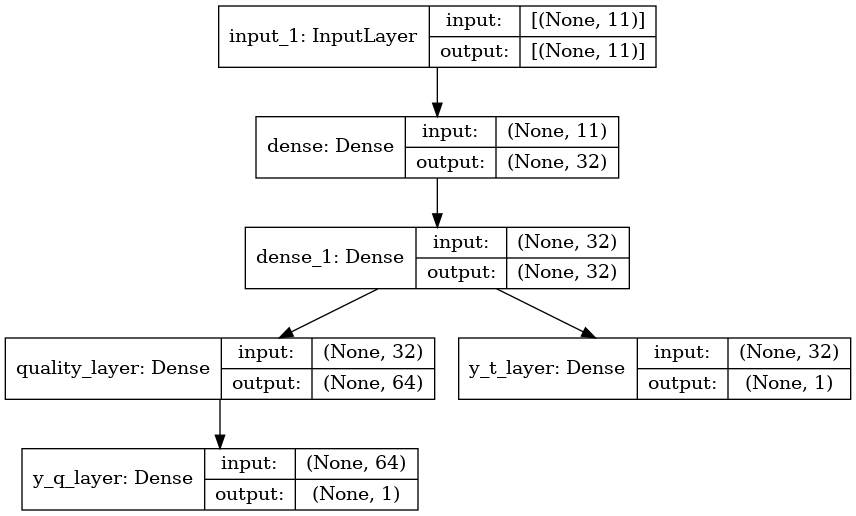

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [19]:
history = model.fit(train_X, train_y, 
                    epochs = 40, validation_data=(val_X, val_y))

Epoch 1/40
130/130 [==============================] - 2s 5ms/step - loss: 30.3064 - y_q_layer_loss: 29.6112 - y_t_layer_loss: 0.6951 - y_q_layer_root_mean_squared_error: 5.4416 - y_t_layer_accuracy: 0.5783 - val_loss: 25.1037 - val_y_q_layer_loss: 24.4021 - val_y_t_layer_loss: 0.7017 - val_y_q_layer_root_mean_squared_error: 4.9398 - val_y_t_layer_accuracy: 0.5812
Epoch 2/40
130/130 [==============================] - 0s 3ms/step - loss: 19.8425 - y_q_layer_loss: 19.1592 - y_t_layer_loss: 0.6833 - y_q_layer_root_mean_squared_error: 4.3771 - y_t_layer_accuracy: 0.6209 - val_loss: 14.8888 - val_y_q_layer_loss: 14.2034 - val_y_t_layer_loss: 0.6854 - val_y_q_layer_root_mean_squared_error: 3.7687 - val_y_t_layer_accuracy: 0.6190
Epoch 3/40
130/130 [==============================] - 0s 3ms/step - loss: 10.7627 - y_q_layer_loss: 10.1068 - y_t_layer_loss: 0.6558 - y_q_layer_root_mean_squared_error: 3.1791 - y_t_layer_accuracy: 0.6811 - val_loss: 7.6101 - val_y_q_layer_loss: 6.9598 - val_y_t_laye

## Metrics

In [20]:
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=val_X, y=val_y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

33/33 [==============================] - 0s 1ms/step - loss: 0.6153 - y_q_layer_loss: 0.5606 - y_t_layer_loss: 0.0548 - y_q_layer_root_mean_squared_error: 0.7487 - y_t_layer_accuracy: 0.9884

loss: 0.61532062292099
wine_quality_loss: 0.5605606436729431
wine_type_loss: 0.05475997179746628
wine_quality_rmse: 0.7487059831619263
wine_type_accuracy: 0.988394558429718


# Conclusions, Fork & Improve
I realy like this kind of models! They can save a lot of time and money for models in production that must be retrained daily, and that are using the same data to predict more that one variable. 

In the Model I used an additional Dense layer that maybe don't add a lot of value to the prediction but I want to show that it's possible create different branches inside the same model. 

It's an easy and powerful technique! I hope that you haver enjoyed it.

> Feel free to fork or copy the Notebook, if you like it please upvote it. It will encourage me a lot to share more work like this one. 

There are a lot of ways to improve the result obtained with this notebook. 

Of course that you can buind a completly new model changing the layers. 

You can use callback funtions: to save the best model, to stop early the training. But be carefull because now you have more variables to watch, you need to decide with one to use in the callback functions.

It's possible to use a different learning rate, or modify it in a callback function too. 

If you fork the model and get a different result I will be really happy to discuss it in the comments section :-) 

# Inspirations
The only inspiration is a course tat I'm following on Coursera: Advanced Techniques with Tensorflow. Expect more notebooks like this one with more advanced topics as I'm advancing with the specialization. 

There are not so much models with Multiple Outputs in Kaggle, sincerely I can't found any actual. 

Just a special mention to the Dataset Used: 
https://www.kaggle.com/datasets/rajyellow46/wine-quality

Datased original in: 
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

# More Notebooks in the TensorFlow Serie. 
I'm working in a serie of notebooks with some interesting techniques in Tensorflow: Tensorflow beyond the basics.

**How to create a Siamese Network to compare images.** 
https://www.kaggle.com/code/peremartramanonellas/how-to-create-a-siamese-network-to-compare-images

**Improve Tensorflow performance with Graph mode.**
https://www.kaggle.com/code/peremartramanonellas/improve-tensorflow-performance-with-graph-mode
Compare the Eager vs Graph mode and improve execution of custom models and Data treatment. 
